# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1]:
from collections import Counter
from gensim import corpora, similarities
from gensim.models import word2vec
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_multiple_whitespaces, \
                                         strip_non_alphanum, strip_numeric, strip_punctuation, strip_short, stem_text
from matplotlib import colors as mcolors
from nltk import tokenize  # We will need nltk and nltk_data.
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import gc
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import numpy.linalg as ln
import pandas as pd       
import seaborn as sns
import warnings

%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
# For work with google colab.
from google.colab import drive
import os
import nltk
nltk.download('punkt')
drive.mount('/content/drive/')
os.chdir('drive/My Drive/Y-Data/Deep Learning/assignment3/')

In [5]:
data = pd.read_csv('lyrics.csv', header=0)

print(data.shape)
data.head()

(362237, 6)


,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [6]:
# Check if there are nans in the lyrics column.
len(data[data.lyrics.isnull()])

95680

In [7]:
# Create a list of non-null texts, grouped by genres to further reuse.
texts_by_genres = data[['lyrics', 'genre']].dropna().groupby(['genre']).agg(lambda x: '\n'.join(x)).reset_index()

# Split the texts into sentences.
sentences_by_genres = {
    genre: tokenize.sent_tokenize(texts_by_genres[texts_by_genres.genre==genre].lyrics.values[0]) 
    for genre in texts_by_genres.genre}

In [8]:
remove_punctuation_marks = lambda word: strip_punctuation(word.replace("'", ""))

preprocessors = [
    stem_text,                   # Reduce words to their base forms - doesn't work well, e.g. stem of 
                                 # "Mary" should be "Mary" but "mar" is returned, doesn't stem some words.
    lambda word: word.lower(),   # Lowercase the word.
    strip_numeric,               # Remove digits.
    strip_non_alphanum,          # Remove non-alphanumeric characters.
    strip_multiple_whitespaces,  # Remove repeating whitespaces.
    strip_short,                 # Remove words with length less than 3.
    remove_punctuation_marks,    # Remove the "'" character and replace punctuation marks by a whitespace.
    remove_stopwords             # Remove stopwords.
                                 # TODO(maria): Consider specifying stopwords manually rather than using a 
                                 # built-in list.
]

# Process the sentences: remove stop words, punctuation marks, and tokenize them.
words_by_sentences_by_genre = [
    [preprocess_string(sentence, preprocessors) for sentence in sentences_by_genres[genre]]
    for genre in texts_by_genres.genre
]

In [9]:
num_features = 300                         # Word vector dimensionality.                  
min_word_count = 40                        # Minimum word count.               
num_workers = multiprocessing.cpu_count()  # Number of threads to run in parallel.
context = 10                               # Context window size.                                                                  
downsampling = 1e-3                        # Downsample setting for frequent words.

all_sentences = np.concatenate(words_by_sentences_by_genre)
model = word2vec.Word2Vec(all_sentences, size=num_features, min_count=min_word_count, \
                          window=context, sample=downsampling, workers=num_workers)

# We don't plan to train the model any further, therefore, 
# we call init_sims to make the model more memory-efficient.
model.init_sims(replace=True)

In [10]:
del data
del sentences_by_genres
gc.collect()

355

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [ ]:
words = ['glass', 'black', 'student']

for word in words:
    similar_word, similarity = model.wv.most_similar(word, topn=1)[0]
    print('The most similar word to "%s" is "%s" (similarity %.2f)' % (word, similar_word, similarity))

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [10]:
def print_stats(w1, w2):
    v1 = model.wv[w1]
    v2 = model.wv[w2]
    cosine_dist = np.dot(v1, v2) / (ln.norm(v1) * ln.norm(v2))
    euclidean_dist = ln.norm(v1 - v2)
    similarity = model.wv.similarity(w1, w2)
    print('"%s" and "%s": cosine distance %.2f, Euclidean distance %.2f, similarity %.2f' % 
         (w1, w2, cosine_dist, euclidean_dist, similarity))

# Try out similar words.
print_stats('glass', 'shard')
print_stats('black', 'white')

# Compute stats for uncorrelated words.
print_stats('bacardi', 'education')

"glass" and "shard": cosine distance 0.50, Euclidean distance 1.00, similarity 0.50
"black" and "white": cosine distance 0.52, Euclidean distance 0.98, similarity 0.52
"bacardi" and "education": cosine distance -0.07, Euclidean distance 1.47, similarity -0.07


In [11]:
def print_stats_2(positive, negative):
    w2, similarity = model.wv.most_similar(positive=positive, negative=negative, topn=1)[0]
    v2 = model.wv[w2] 
    v1 = np.sum(model.wv[positive], axis=0) - np.sum(model.wv[negative], axis=0)
    cosine_dist = np.dot(v1, v2) / (ln.norm(v1) * ln.norm(v2))
    euclidean_dist = ln.norm(v1 - v2)
    print('The most similar word "%s": cosine distance %.2f, Euclidean distance %.2f, similarity %.2f' % 
         (w2, cosine_dist, euclidean_dist, similarity))

print_stats_2(['white', 'glass'], ['shard'])

The most similar word "black": cosine distance 0.40, Euclidean distance 1.43, similarity 0.40


We see that cosine distance has better correlatation to the similarity of the model.

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [12]:
df = pd.read_csv('twitter/SemEval2015-English-Twitter-Lexicon.txt', header=None, delimiter='\t')
df.rename(columns={0: 'score', 1: 'entry'}, inplace=True)
df.head()

,score,entry
0,0.984,loves
1,0.984,#inspirational
2,0.969,amazing
3,0.969,#peaceful
4,0.953,#greatness


In [13]:
vocab = set(model.wv.vocab)
y = df[["score"]].values[:,0]

mask = []
all_entry_words = []
for entry, in df[["entry"]].values:
    # Run the same preprocessors as for the lyrics dataset.
    entry_words = preprocess_string(entry, preprocessors)
    diff = set(entry_words) - set(vocab)
    # Skip words missing in the lyrics vocabulary, and entries consisting of several words.
    include = len(diff) == 0 and len(entry_words) == 1
    all_entry_words.append(entry_words if include else [])
    mask.append(include)
all_entry_words = np.concatenate(np.array(all_entry_words)[mask])
X = np.array([model.wv[word] for word in all_entry_words])
y = np.array(y)[mask]
y = (y + 1.0) / 2.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg_model = LinearRegression().fit(X_train, y_train)

print('Accuracy on the train set %.2f' % (1 - mean_squared_error(y_train, reg_model.predict(X_train))))
print('Accuracy on the test set %.2f' % (1 - mean_squared_error(y_test, reg_model.predict(X_test))))

Accuracy on the train set 0.98
Accuracy on the test set 0.95


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [14]:
sentiment_vocab = set(all_entry_words)
diff = list(vocab - sentiment_vocab)
word_vectors = np.array([model.wv[word] for word in diff])
scores = reg_model.predict(word_vectors)

order = scores.argsort()
result = np.array([np.array(diff)[order], scores[order]]).transpose()

print('The words with the highest negative sentiment:\n', result[0:10])
print('The words with the highest positive sentiment:\n', result[result.shape[1]-10:])

The words with the highest negative sentiment:
 [['rut' '-0.21469915']
 ['scab' '-0.20537305']
 ['chock' '-0.15450889']
 ['scaveng' '-0.15445417']
 ['slit' '-0.110904336']
 ['suffer' '-0.10786027']
 ['maggot' '-0.10722619']
 ['mislead' '-0.10245758']
 ['bankrupt' '-0.0920164']
 ['stuck' '-0.09137946']]
The words with the highest positive sentiment:
 [['holiday' '1.1254061']
 ['zion' '1.1282489']
 ['fizzi' '1.1370951']
 ['diddlei' '1.1371391']
 ['gether' '1.159827']
 ['unpredict' '1.1743735']
 ['awhil' '1.186162']
 ['harmoni' '1.193716']]


### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [17]:
n_words_over_all = 3000      # Number of most frequent words to pick.

# Find most common words.
all_words = np.concatenate(all_sentences)
most_common_over_all = Counter(all_words).most_common(n_words_over_all)
# Convert to dictionary.
most_common_over_all = {k: v for k, v in most_common_over_all}

In [18]:
all_common_words = list(most_common_over_all.keys())
occurences = np.array([most_common_over_all[w] for w in all_common_words])

n_genres = len(texts_by_genres.genre)

# Compute for each word its relative abundance in each of the genres.
occurences_per_genre = []
for i in range(n_genres):
    c = Counter(np.concatenate(words_by_sentences_by_genre[i]))
    occurences_per_genre.append([c[w] for w in all_common_words])
occurences_per_genre = np.array(occurences_per_genre)

In [19]:
# Compute the background distribution.
d = np.divide(occurences_per_genre, occurences, dtype=float)
d

array([[0.06801121, 0.04336646, 0.04099005, ..., 0.01311475, 0.1083151 ,
        0.06017505],
       [0.03267585, 0.02485635, 0.0236765 , ..., 0.01857923, 0.00875274,
        0.02078775],
       [0.00593574, 0.00417508, 0.00435509, ..., 0.00218579, 0.00328228,
        0.0131291 ],
       ...,
       [0.25610736, 0.19599873, 0.16226025, ..., 0.24699454, 0.05032823,
        0.10175055],
       [0.02270761, 0.01693326, 0.01117368, ..., 0.00327869, 0.04157549,
        0.00875274],
       [0.32235766, 0.35926879, 0.2961464 , ..., 0.21967213, 0.4463895 ,
        0.41575492]])

In [20]:
top_n = 50       # Number of most frequent words to pick for each genre.

words_arr = np.array(all_common_words)

top_words_per_genre = []
scores_per_genre = []
for i in range(n_genres):
    mask = (-d[i]).argsort()[:top_n]
    top_words_per_genre.append(words_arr[mask])
    scores_per_genre.append(d[i][mask])
top_words_per_genre = np.array(top_words_per_genre)
scores_per_genre = np.array(scores_per_genre)

all_top_words = np.unique(np.concatenate(top_words_per_genre))

[['gray' 'Country']
 ['green' 'Electronic']
 ['blue' 'Folk']
 ['yellow' 'Hip-Hop']
 ['pink' 'Indie']
 ['black' 'Jazz']
 ['purple' 'Metal']
 ['moccasin' 'Not Available']
 ['indigo' 'Other']
 ['orchid' 'Pop']
 ['khaki' 'R&B']
 ['salmon' 'Rock']]


Text(0.5, 1.0, 't-SNE visualization')

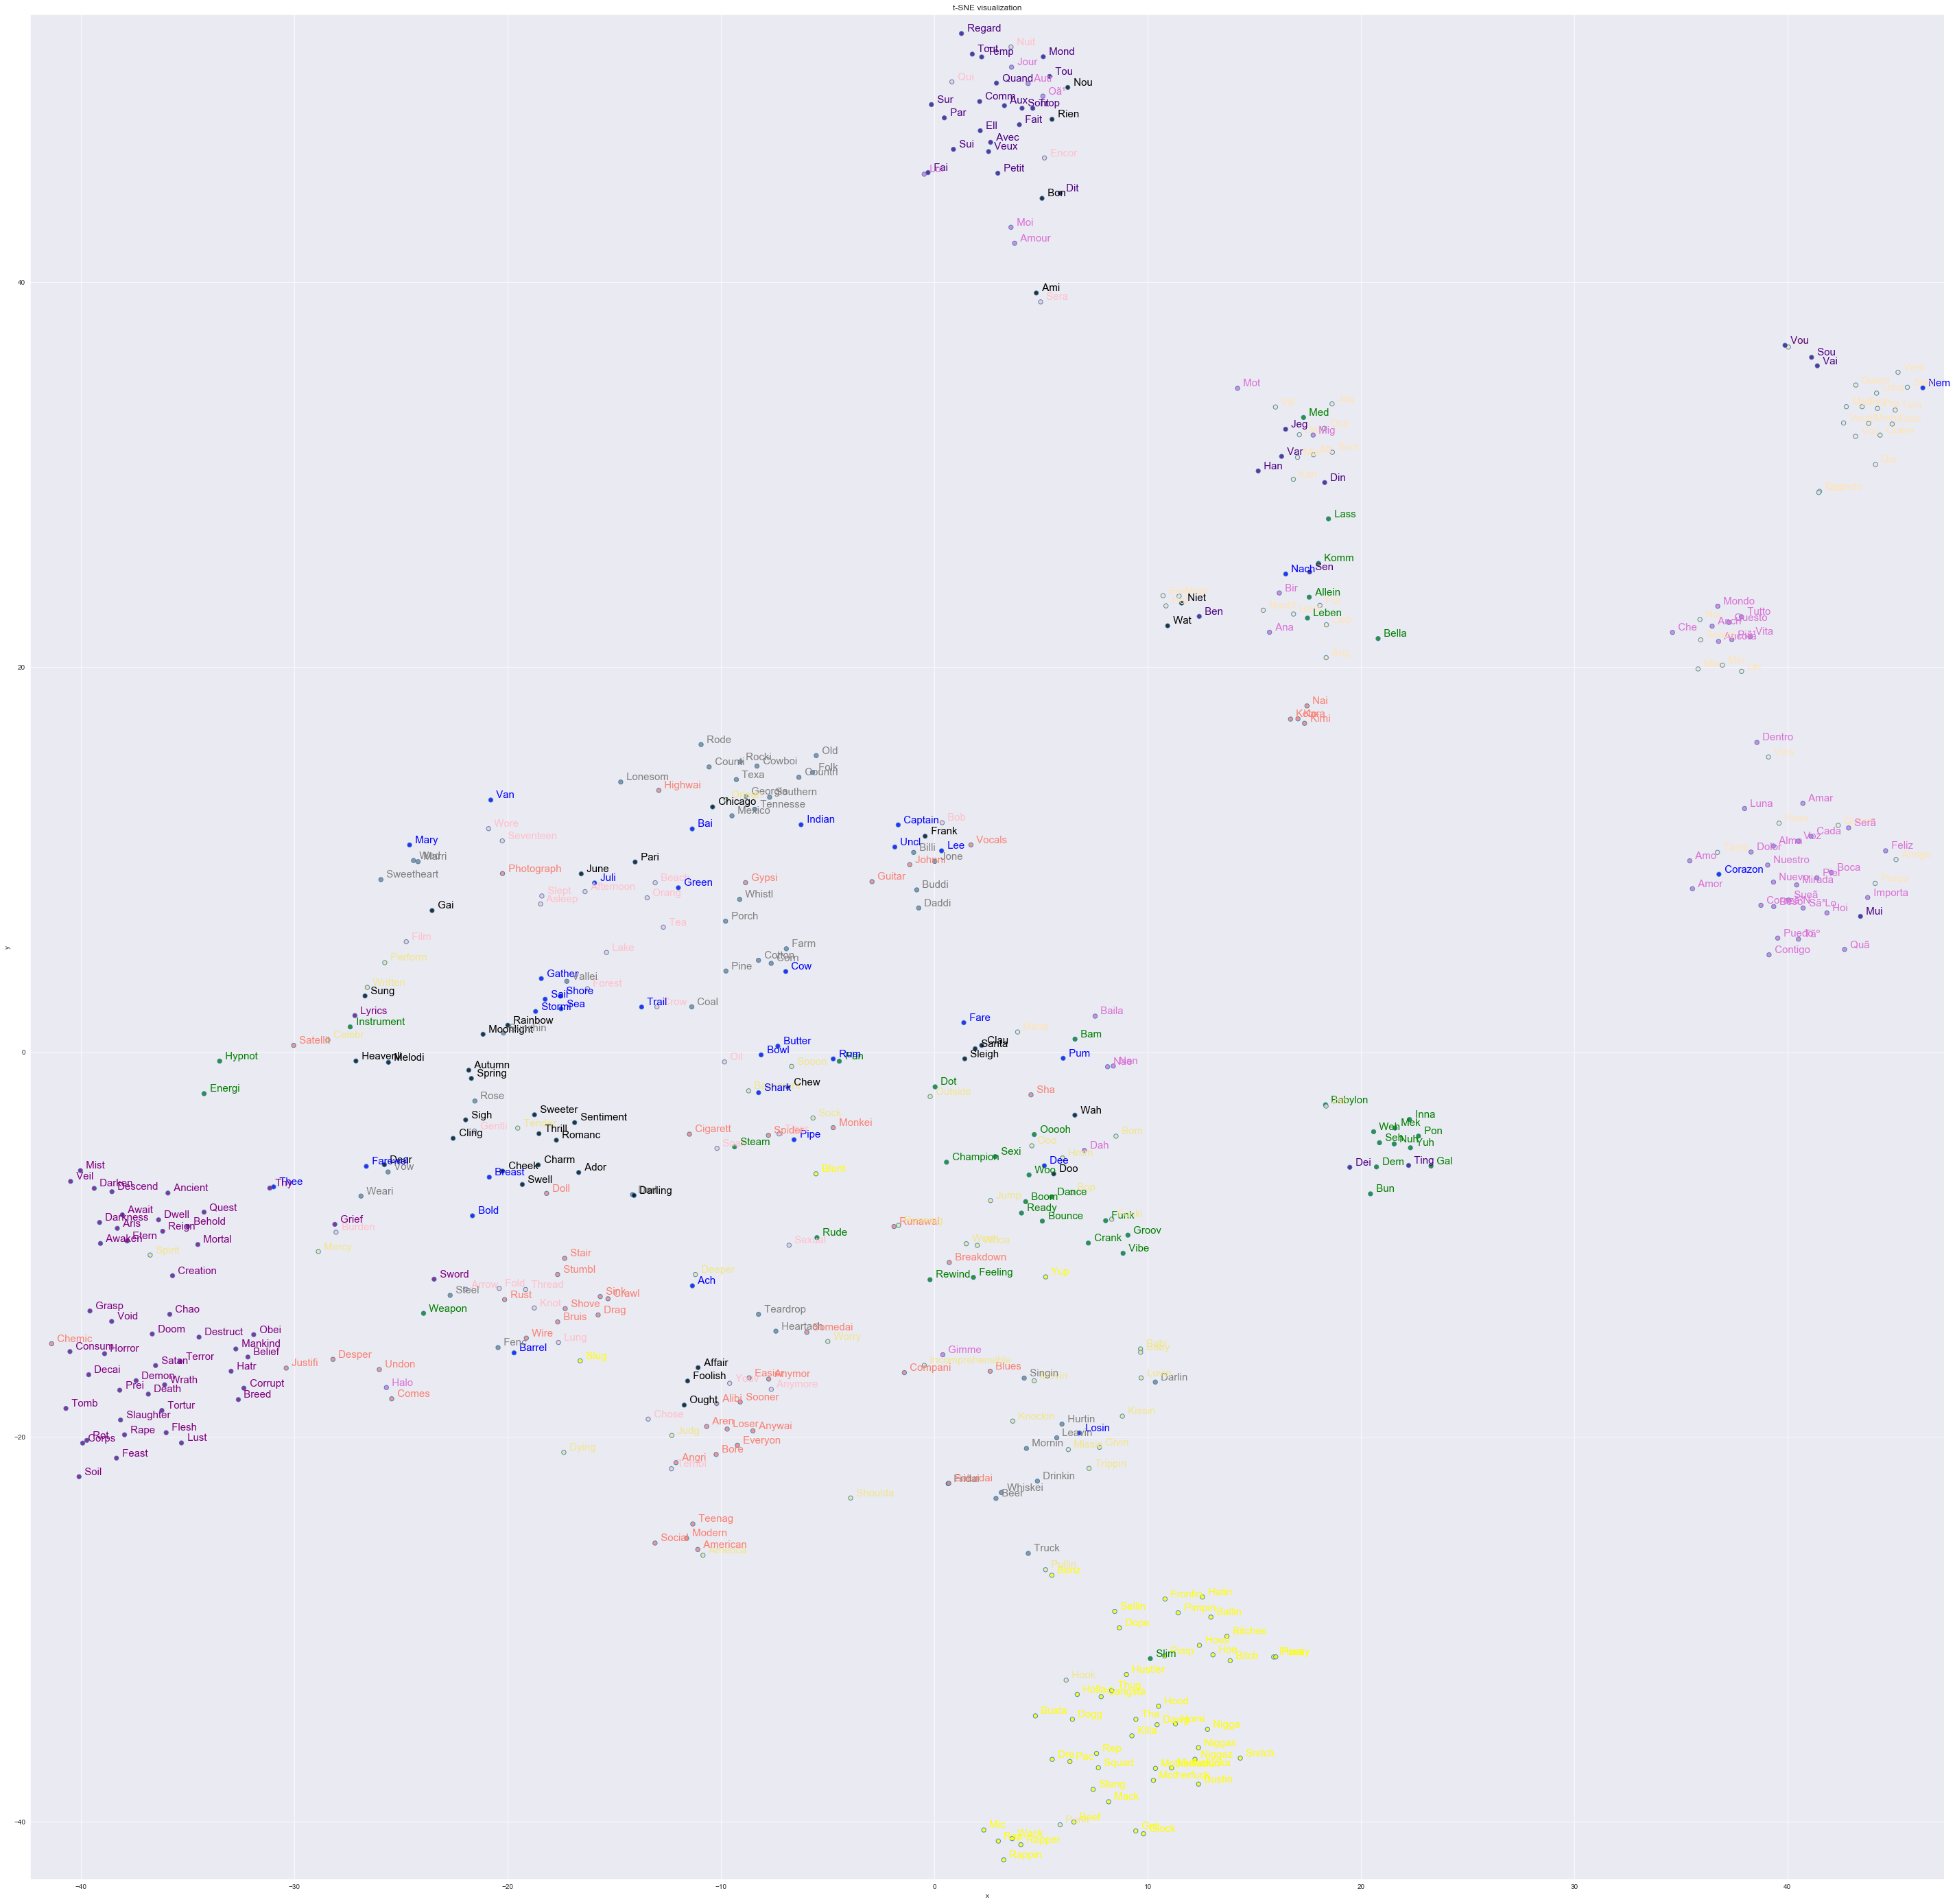

In [21]:
css_colors = ['gray', 'green', 'blue', 'yellow', 'pink', 'black', 'purple', 'moccasin', 'indigo', 'orchid', 'khaki', 'salmon']
css_color_codes = dict(**mcolors.CSS4_COLORS)

def get_genre_index(word):
    indices = np.argwhere(top_words_per_genre==word)
    scores = [scores_per_genre[genre_index, word_index] for genre_index, word_index in indices]
    return indices[np.argmax(scores)][0]

get_color = lambda word: css_color_codes[css_colors[get_genre_index(word)]]

arrays = np.empty((0, num_features), dtype='f')

word_labels = all_top_words
color_list  = [get_color(w) for w in all_top_words]
arrays = model.wv[all_top_words]
    
# Reduce the dimensionality from 300 to 16 dimensions with PCA.
pca = PCA(n_components=16).fit_transform(arrays)
    
# Find t-SNE coordinates for 2 dimensions.
np.set_printoptions(suppress=True)
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(pca)
    
fig, _ = plt.subplots()
fig.set_size_inches(50, 50)
df = pd.DataFrame({'x': [x for x in Y[:,0]], 'y': [y for y in Y[:,1]], 
                   'words': word_labels, 'color': color_list})
p1 = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o",
                 scatter_kws={'s': 40, 'facecolors': df['color']})
    
# Add annotations.
for line in range(0, df.shape[0]):
    title = '  ' + df["words"][line].title()
    p1.text(df["x"][line], df['y'][line], title,
            horizontalalignment='left', verticalalignment='bottom', size='medium',
            color=df['color'][line], weight='normal').set_size(15)

# TODO(maria): Find out how to add a legend with a map of colors to genres, and remove this line.
print(np.stack([css_colors, texts_by_genres.genre], axis=1))

plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)
            
plt.title('t-SNE visualization')

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [23]:
n_genres = len(texts_by_genres.genre)
string_sentences = []
y = []
for i in range(n_genres):
    for words_by_sentences in words_by_sentences_by_genre[i]:
        string_sentences.append(' '.join(words_by_sentences))
        y.append(i)
    
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(string_sentences)    
y = np.array(y)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

(979261, 392925) (979261,)


In [18]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

print('Accuracy on the train set %.2f' % clf.score(X_train, y_train))
print('Accuracy on the test set %.2f' % clf.score(X_test, y_test))

Accuracy on the train set 0.50
Accuracy on the test set 0.48


Show the confusion matrix.

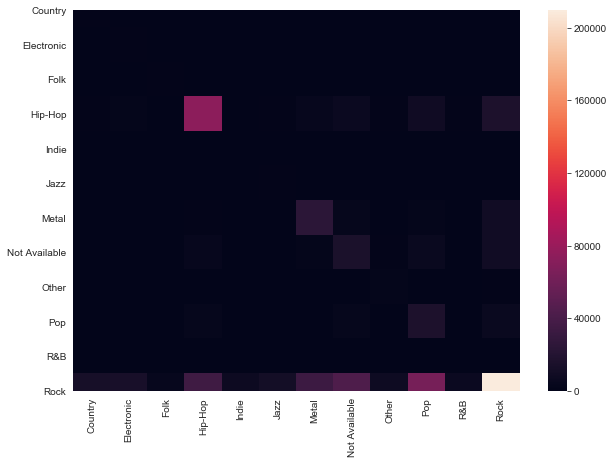

In [19]:
def show_confusion_matrix(y_pred, y_true):
    m = confusion_matrix(y_pred, y_true)
    plt.figure(figsize = (10,7))
    labels = texts_by_genres.genre
    sns.heatmap(m, xticklabels=labels, yticklabels=labels)

show_confusion_matrix(clf.predict(X_train), y_train)

Show the classification report - precision, recall, f1 for each class.

In [20]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test_pred, y_test, target_names=texts_by_genres.genre))

               precision    recall  f1-score   support

      Country       0.06      0.40      0.10       956
   Electronic       0.05      0.50      0.09       811
         Folk       0.17      0.37      0.23      1221
      Hip-Hop       0.61      0.62      0.62     49798
        Indie       0.02      0.39      0.03       140
         Jazz       0.05      0.44      0.09       733
        Metal       0.35      0.54      0.42     17678
Not Available       0.18      0.32      0.23     16931
        Other       0.10      0.25      0.15      2446
          Pop       0.13      0.46      0.21     11934
          R&B       0.01      0.33      0.01        67
         Rock       0.82      0.46      0.59    191064

     accuracy                           0.48    293779
    macro avg       0.21      0.42      0.23    293779
 weighted avg       0.67      0.48      0.54    293779



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [41]:
gc.collect()

22709

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


Accuracy on the train set 0.49
Accuracy on the test set 0.47
               precision    recall  f1-score   support

      Country       0.00      1.00      0.00         1
   Electronic       0.02      0.96      0.04       115
         Folk       0.07      0.90      0.13       138
      Hip-Hop       0.50      0.75      0.60     22464
        Indie       0.00      1.00      0.00         1
         Jazz       0.00      0.93      0.01        15
        Metal       0.08      0.84      0.14      1666
Not Available       0.12      0.47      0.20      5349
        Other       0.02      0.64      0.04       116
          Pop       0.12      0.48      0.19      6614
          R&B       0.00      0.00      0.00         0
         Rock       0.95      0.43      0.59    159374

     accuracy                           0.47    195853
    macro avg       0.16      0.70      0.16    195853
 weighted avg       0.84      0.47      0.56    195853



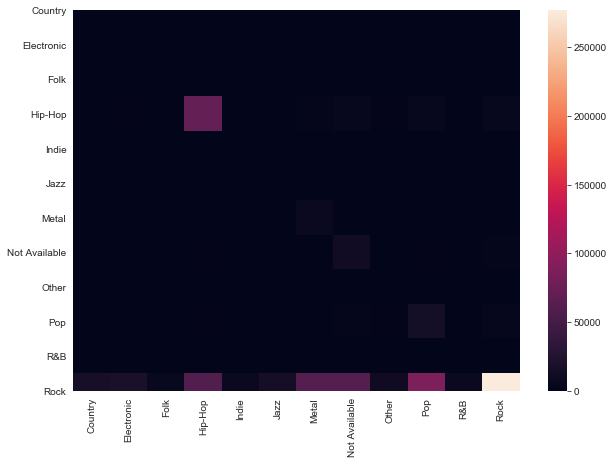

In [49]:
vocab = list(model.wv.vocab)
tfidf = TfidfVectorizer(stop_words = 'english')
X = tfidf.fit_transform(string_sentences)    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf_tf = MultinomialNB()
clf_tf.fit(X_train, y_train)

print('Accuracy on the train set %.2f' % clf_tf.score(X_train, y_train))
print('Accuracy on the test set %.2f' % clf_tf.score(X_test, y_test))
show_confusion_matrix(clf_tf.predict(X_train), y_train)
print(classification_report(clf_tf.predict(X_test), y_test, target_names=texts_by_genres.genre))

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.